# Pathological Myopia Prediction Model

### Step 1: Import libraries

In [30]:
import os, glob, cv2, random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from sklearn.model_selection import train_test_split

### Step 2: Read dataset

In [9]:
df = pd.read_csv("./dataset/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


### Step 3. Extracting Pathological Myopia & Normal information from the dataset

##### Myopia images

In [10]:
def has_myopia(text):
    if "pathological myopia" in text:
        return 1
    else:
        return 0

In [13]:
df["left_myopia"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_myopia(x))
df["right_myopia"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_myopia(x))

In [12]:
left_myopia = df.loc[(df.M ==1) & (df.left_myopia == 1)]["Left-Fundus"].values
left_myopia[:15]

array(['13_left.jpg', '18_left.jpg', '35_left.jpg', '106_left.jpg',
       '144_left.jpg', '145_left.jpg', '174_left.jpg', '225_left.jpg',
       '379_left.jpg', '401_left.jpg', '481_left.jpg', '504_left.jpg',
       '525_left.jpg', '741_left.jpg', '771_left.jpg'], dtype=object)

In [15]:
right_myopia = df.loc[(df.M ==1) & (df.right_myopia == 1)]["Right-Fundus"].values
right_myopia[:15]

array(['13_right.jpg', '16_right.jpg', '18_right.jpg', '46_right.jpg',
       '54_right.jpg', '86_right.jpg', '106_right.jpg', '145_right.jpg',
       '214_right.jpg', '233_right.jpg', '390_right.jpg', '401_right.jpg',
       '475_right.jpg', '504_right.jpg', '525_right.jpg'], dtype=object)

In [16]:
print("Number of images in left myopia: {}".format(len(left_myopia)))
print("Number of images in right myopia: {}".format(len(right_myopia)))

Number of images in left myopia: 216
Number of images in right myopia: 241


##### Normal images

In [17]:
left_normal = df.loc[(df.M ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(230,random_state=42).values
right_normal = df.loc[(df.M ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(230,random_state=42).values

In [19]:
myopia = np.concatenate((left_myopia,right_myopia),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

print(len(myopia),len(normal))

457 460


### Step 4: Creating dataset from images

In [22]:
image_set_dir = "C:/Users/rocky/OneDrive/Desktop/URO/dataset/archive/preprocessed_images"

image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(image_set_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [23]:
dataset = create_dataset(myopia, 1)

100%|██████████| 457/457 [00:03<00:00, 139.17it/s]


In [24]:
len(dataset)

454

In [25]:
dataset = create_dataset(normal, 0)

100%|██████████| 460/460 [00:05<00:00, 87.56it/s]


In [26]:
len(dataset)

914

##### Image presentation

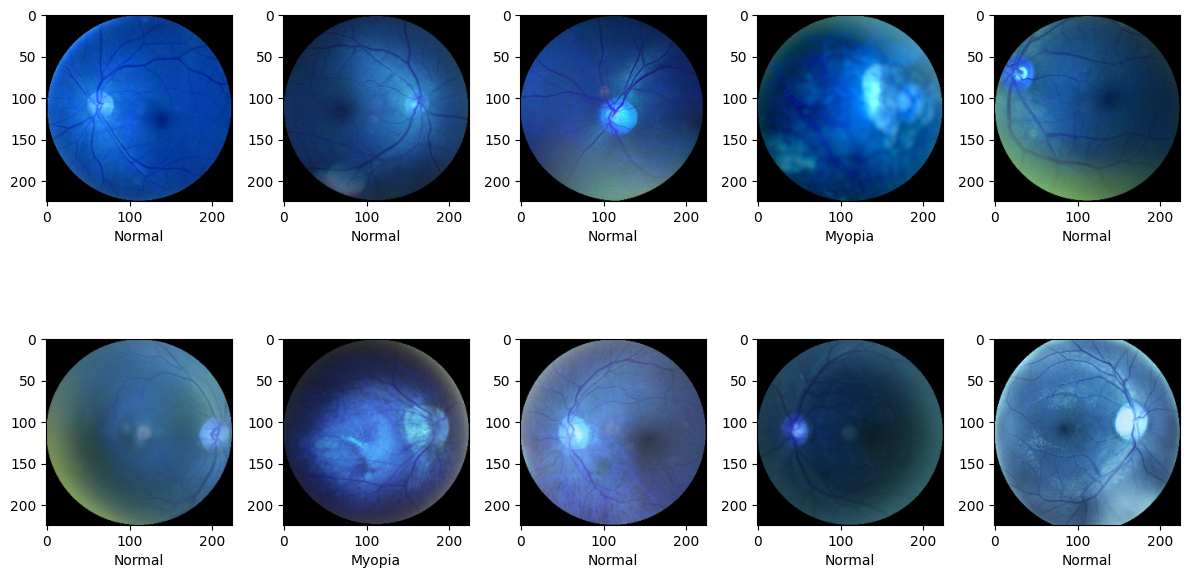

In [27]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Myopia"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

##### Dividing dataset into x (features) & y (target)

In [31]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

### Step 5: Creating Model

In [32]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))



80134624/80134624 [==============================] - 4s 0us/step


In [33]:
for layer in vgg.layers:
    layer.trainable = False

In [34]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [36]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

##### Early stopping for statistical optimization

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [38]:
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [39]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15


23/23 [==============================] - 135s 6s/step - loss: 2.2681 - accuracy: 0.8304 - val_loss: 0.1936 - val_accuracy: 0.9727
Epoch 2/15
23/23 [==============================] - 149s 7s/step - loss: 0.2133 - accuracy: 0.9795 - val_loss: 0.1031 - val_accuracy: 0.9781
Epoch 3/15
23/23 [==============================] - 146s 6s/step - loss: 0.0386 - accuracy: 0.9986 - val_loss: 0.1284 - val_accuracy: 0.9781
Epoch 4/15
23/23 [==============================] - 148s 6s/step - loss: 1.9404e-04 - accuracy: 1.0000 - val_loss: 0.1383 - val_accuracy: 0.9781
Epoch 5/15
23/23 [==============================] - 150s 7s/step - loss: 4.0601e-05 - accuracy: 1.0000 - val_loss: 0.1347 - val_accuracy: 0.9781
Epoch 6/15
23/23 [==============================] - 143s 6s/step - loss: 2.8796e-05 - accuracy: 1.0000 - val_loss: 0.1343 - val_accuracy: 0.9781
Epoch 7/15
23/23 [==============================] - 142s 6s/step - loss: 2.2935e-05 - accuracy: 1.0000 - val_loss: 0.1339 - val_accuracy: 0.

In [40]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

6/6 [==============================] - 28s 5s/step - loss: 0.1287 - accuracy: 0.9781
loss: 0.1286718249320984
Accuracy: 0.9781420826911926


In [54]:
pred_y=model.predict(x_test)
y_pred=(pred_y > 0.5).astype("int32")

6/6 [==============================] - 23s 4s/step


In [57]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9781420765027322

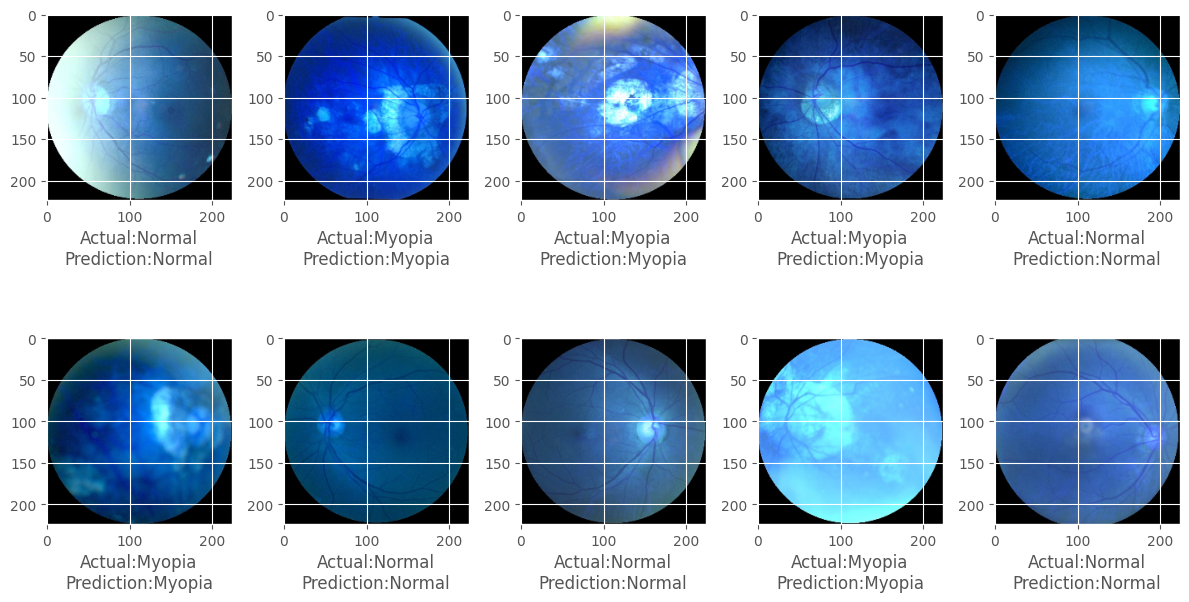

In [58]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Myopia"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Myopia"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))

plt.tight_layout() 

In [59]:
model.save('./models/myopia_model.h5')

c:\Users\rocky\OneDrive\Desktop\URO\Myopia_Prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
